## Import 

In [1]:
# Neural Network
from tensorflow.keras.applications import imagenet_utils
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf

# For measuring the inference time.
import time
import random

# Computer Vision
import cv2

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Math
import numpy as np

# File handling
import pickle

Using TensorFlow backend.


## Loading Images

In [2]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [3]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data-Images",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=2591,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 2453 images belonging to 3 classes.


In [4]:
# Image classes
image_gen.class_indices

{'Assault Rifle': 0, 'Handgun': 1, 'No Firearm': 2}

In [5]:
# Image shape
image_gen.image_shape

(300, 300, 3)

## Separating To Images and Labels

In [6]:
images, labels = next(image_gen)

In [7]:
images.shape

(2453, 300, 300, 3)

In [8]:
labels.shape

(2453, 3)

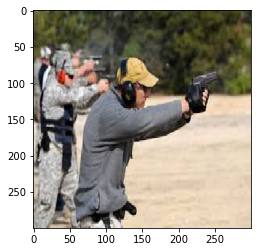

In [9]:
plt.imshow(images[23])

In [10]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# More with Labels

In [52]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [53]:
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
encoder_path = "labels_encoded.pickle"
f = open(encoder_path, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label encoder...


In [54]:
lb.classes_

array([0, 1, 2])

In [55]:
labels.shape

(2453, 3, 2)

In [56]:
labels[23]

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Loading Model and Prediction

In [45]:
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)

# Image Classes
classes = ['Assault Rifle', 'Handgun', 'No Firearm']


# Prediction Function
def predict(model, image_num):
    img = images[image_num]  # Loading image
    img = img_to_array(img)  # Transforming image to array
    img = img / 255  # Normalizing Image
    img = np.expand_dims(img, axis=0)  # Expanding dimensions
    predict = model.predict(img)  # Predicting the image
    pred_name = classes[np.argmax(predict)]  # Predicting the name
    prediction = str(round(predict.max() * 100, 3))
    return prediction + '%', pred_name, display_image(images[image_num])

('90.848%', 'Assault Rifle', None)

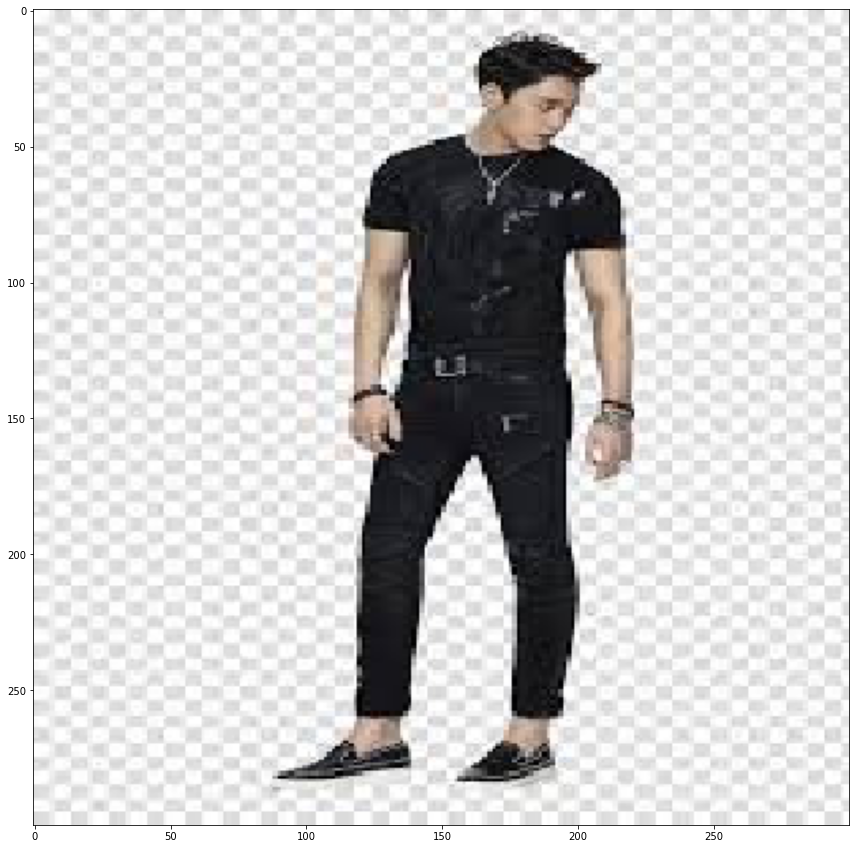

In [48]:
predict(cnn_model, image_num=232)

In [32]:
img = images[4]  # Loading image
img = img_to_array(img)  # Transforming image to array
img = img / 255  # Normalizing Image
img = np.expand_dims(img, axis=0)  # Expanding dimensions
cnn_model.predict(img)  # Predicting the image

array([[9.0832931e-01, 9.1541924e-02, 1.2872512e-04]], dtype=float32)

# IoU (Intersection Over Union)

In [12]:
def compute_iou(boxA, boxB):
    """
    IOU is a form of 
    performance measurement
    for our object detector.
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

# Non-Maximum Suppression

In [13]:
#  Felzenszwalb et al.
def example_non_max_suppression(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

In [14]:
def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

# Selective Search

In [15]:
# Setting a max amount of region proposals used when running selective search
max_proposals = 2_000
max_proposals_infer = 100  # Search for (1) gathering training data and (2) performing inference

In [16]:
# Define the maximum number of positive and negative images to be
# Denerated from each image
max_positive = 30
max_negative = 10

In [17]:
# initialize the input dimensions to the network
input_dimensions = (300, 300)  # 300 by 300 because that's what the CNN Model was tested on
# define the path to the output model
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)  # Loading CNN model from keras

# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
min_probability = 0.80

In [18]:
# initialize OpenCV's selective search implementation and set the
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [19]:
# Input image in selective search
image = images[43]
ss.setBaseImage(image)

# Choosing which selective search
ss.switchToSelectiveSearchQuality()

In [20]:
# run selective search on the input image
start = time.time()
rects = ss.process()  # Run Selective Search
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print(f"[INFO] selective search took {np.round(end - start, decimals=3)} seconds")
print(f"[INFO] {len(rects)} total region proposals")

[INFO] selective search took 1.596 seconds
[INFO] 664 total region proposals


In [21]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:max_proposals_infer]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, input_dimensions,
        interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

In [23]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float64")
boxes = np.array(boxes, dtype="int64")
print(f"[INFO] proposal shape: {proposals.shape}")

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = cnn_model.predict(proposals)  # Predicting the proposals for our desired object
                                      # Result: 100 proposals 300 by 300 image with RGB color
# Probabilty of each proposal (Region of Proposals)
print(f"[INFO] Probabiltiy Scores: {proba}")

[INFO] proposal shape: (100, 300, 300, 3)
[INFO] classifying proposals...
[INFO] Probabiltiy Scores: [[0.5699485  0.42824042 0.00181104]
 [0.56961656 0.42858276 0.0018007 ]
 [0.56774664 0.4304445  0.00180885]
 [0.56738424 0.4307828  0.00183307]
 [0.5688675  0.4293042  0.00182827]
 [0.5682783  0.42990288 0.00181879]
 [0.56739306 0.43077365 0.00183335]
 [0.5685933  0.42958704 0.00181958]
 [0.56823593 0.42994902 0.00181502]
 [0.5692466  0.42892867 0.00182477]
 [0.5675199  0.43066487 0.00181518]
 [0.56775624 0.4304138  0.00182992]
 [0.567653   0.43050763 0.00183939]
 [0.5678256  0.43033975 0.00183462]
 [0.56660265 0.43156612 0.00183122]
 [0.56782556 0.43035132 0.00182305]
 [0.56729466 0.43088445 0.00182091]
 [0.56793755 0.43023357 0.00182887]
 [0.56709975 0.43106687 0.00183338]
 [0.5674131  0.43078074 0.00180611]
 [0.5700191  0.42817965 0.00180128]
 [0.568323   0.42987937 0.00179762]
 [0.56788427 0.4302848  0.00183094]
 [0.56945014 0.42873222 0.00181768]
 [0.56951106 0.42866102 0.00182786]

In [68]:
boxes

array([[174,   0, 268,  69],
       [156,  94, 174, 129],
       [ 31, 160,  42, 204],
       [183, 164, 223, 212],
       [156, 166, 183, 195],
       [197,  78, 212, 128],
       [175, 263, 207, 300],
       [130, 242, 146, 266],
       [149, 133, 165, 168],
       [ 24,  48, 164, 300],
       [122,  64, 129,  86],
       [142, 226, 167, 294],
       [173,  29, 183,  75],
       [  0,   0, 300, 300],
       [ 23,  38, 161, 241],
       [233,  58, 245,  79],
       [198,  74, 213, 106],
       [ 60, 226,  77, 257],
       [250,  91, 264, 105],
       [ 30, 137,  39, 166],
       [ 86,   0, 201, 132],
       [ 29, 242,  72, 300],
       [ 19,  38,  69, 120],
       [  0,  84,  40, 300],
       [142, 100, 160, 134],
       [131, 242, 146, 266],
       [ 93, 112, 134, 131],
       [ 37, 163,  45, 213],
       [134, 292, 150, 300],
       [ 60, 236,  80, 300],
       [ 25, 222,  61, 270],
       [ 45,  43,  57,  60],
       [  8,  53,  15,  85],
       [  0,  39,   7,  95],
       [273, 1

# Filtering Predictions

In [69]:
# # find the index of all predictions that are positive for the
# # "Assault Rifle" class
# print("[INFO] applying NMS...")
# labels = lb.classes_[np.argmax(proba, axis=1)]
# idxs = np.where(labels == 0)[0] # Assault Rifle
# # use the indexes to extract all bounding boxes and associated class
# # label probabilities associated with the "Assault Rifle" class
# boxes = boxes[idxs]
# proba = proba[idxs][:, 1]
# # further filter indexes by enforcing a minimum prediction
# # probability be met
# idxs = np.where(proba >= min_probability)
# boxes = boxes[idxs]
# proba = proba[idxs]







# find the index of all predictions that are greater
# than the minimum probability
print("[INFO] applying NMS...")
idxs = np.where(proba >= min_probability)[0]

# further filter indexes by enforcing a minimum prediction
# probability be met
boxes = boxes[idxs]
proba = proba[idxs]

[INFO] applying NMS...


# View Results

In [70]:
# loop over the region proposals in chunks (so we can better
# visualize them)
# for i in range(0, len(rects), 100):
#     # clone the original image so we can draw on it
#     output = image.copy()
#     # loop over the current subset of region proposals
#     for (x, y, w, h) in rects[i:i + 100]:
#         # draw the region proposal bounding box on the image
#         color = [random.randint(0, 255) for j in range(0, 3)]
#         cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
#     # show the output image
#     cv2.imshow("Output", output)
#     key = cv2.waitKey(0) & 0xFF
#     # if the `q` key was pressed, break from the loop
#     if key == ord("q"):
#         break

In [ ]:
# clone the original image so that we can draw on it
clone = image.copy()
# loop over the bounding boxes and associated probabilities
for (box, prob) in zip(boxes, proba):
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = box
    cv2.rectangle(clone, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"Assault Rifle: {np.round(prob * 100, decimals=3)}%"
    cv2.putText(clone, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output after *before* running NMS
cv2.imshow("Before NMS", clone)
cv2.waitKey(0)

In [ ]:
# run non-maxima suppression on the bounding boxes
boxIdxs = non_max_suppression(boxes, proba)
# loop over the bounding box indexes
for i in boxIdxs:
    # draw the bounding box, label, and probability on the image
    (startX, startY, endX, endY) = boxes[i]
    cv2.rectangle(image, (startX, startY), (endX, endY),
        (0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    text = f"Assault Rifle: {np.round(proba[i] * 100, decimals=3)}%"
    cv2.putText(image, text, (startX, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
# show the output image *after* running NMS
cv2.imshow("After NMS", image)
cv2.waitKey(0)